In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
import pandas as pd
import matplotlib
import xarray as xr
import cmaps
import matplotlib.ticker as mticker

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [18]:
ds = xr.open_dataset(r'E:/PINN/PINN-usual-z-change-eqn-buoy-example2/data/CCMP_Wind_Analysis_20231220_V03.1_L4.nc')
print(ds)

<xarray.Dataset>
Dimensions:    (time: 4, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 2023-12-20 ... 2023-12-20T18:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 ...
    vwnd       (time, latitude, longitude) float32 ...
    ws         (time, latitude, longitude) float32 ...
    nobs       (time, latitude, longitude) float32 ...
Attributes: (12/54)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    time_coverage_e

In [19]:
# 提取第三个时间点的数据
time_index = 3  # 第三个时间点的索引
uwnd = ds['uwnd'][time_index]
vwnd = ds['vwnd'][time_index]
ws = ds['ws'][time_index]

In [20]:
# 选择特定的经纬度范围
lon_range = (179.8, 230)
lat_range = (-4.2, 46)

# 选择在经纬度范围内的数据
mask_lon = (ds['longitude'] >= lon_range[0]) & (ds['longitude'] <= lon_range[1])
mask_lat = (ds['latitude'] >= lat_range[0]) & (ds['latitude'] <= lat_range[1])

uwnd = uwnd.sel(longitude=ds['longitude'][mask_lon], latitude=ds['latitude'][mask_lat])
vwnd = vwnd.sel(longitude=ds['longitude'][mask_lon], latitude=ds['latitude'][mask_lat])
ws = ws.sel(longitude=ds['longitude'][mask_lon], latitude=ds['latitude'][mask_lat])

In [21]:
selected_u = uwnd[ 0:200, 0:200].values
selected_v = vwnd[ 0:200, 0:200].values
wind_speed = np.sqrt(selected_v**2 + selected_u**2)

# 假设你的数据维度和范围
lon = np.linspace(180, 230, 200)  # 示例经度范围
lat = np.linspace(-4, 46, 200)    # 示例纬度范围
lon, lat = np.meshgrid(lon, lat)  # 创建经纬度的网格

In [22]:
data = xr.open_dataset(r'E:/PINN/PINN-usual-z-change-eqn-example2/data/cmems_obs-wind_glo_phy_nrt_l3-hy2d-hscat-des-0.25deg_P1D-i_1737010693738.nc')
print(data)

<xarray.Dataset>
Dimensions:           (time: 1, latitude: 200, longitude: 200)
Coordinates:
  * time              (time) datetime64[ns] 2023-12-20
  * latitude          (latitude) float32 -3.875 -3.625 -3.375 ... 45.62 45.88
  * longitude         (longitude) float32 -179.9 -179.6 -179.4 ... -130.4 -130.1
Data variables:
    eastward_wind     (time, latitude, longitude) float32 ...
    measurement_time  (time, latitude, longitude) float32 ...
    northward_wind    (time, latitude, longitude) float32 ...
    wind_speed        (time, latitude, longitude) float32 ...
    wind_to_dir       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             Global Ocean - Wind - HY-2D HSCAT - 25km daily Descend...
    institution:       EUMETSAT/OSI SAF/KNMI
    source:            HY-2D HSCAT
    history:           N/A
    references:        HY-2 Wind Product User Manual, https://osi-saf.eumetsa...
    comment:           Orbit period and inclination are

In [23]:
U_star = data['eastward_wind'] # T*L*X*Y N x T
V_star = data['northward_wind']
data1 = U_star.values  # iloc[:, 0] 选择所有行的第一列，.values 转换为 numpy 数组
reshaped_data1 = data1.reshape((200, 200))
# v
data2 = V_star.values  # iloc[:, 0] 选择所有行的第一列，.values 转换为 numpy 数组
reshaped_data2 = data2.reshape((200, 200))

In [24]:
# 假设你的数据维度和范围
lon = np.linspace(150, 200, 200)  # 示例经度范围
lat = np.linspace(-23, 27, 200)    # 示例纬度范围
lon, lat = np.meshgrid(lon, lat)  # 创建经纬度的网格

# 假设 selected_u 和 selected_v 分别是在特定时间和层级的 U 和 V 分量的数据
selected_u2 = reshaped_data1[ :, :]
selected_v2 = reshaped_data2[ :, :]
wind_speed_obs = np.sqrt(selected_v2**2 + selected_u2**2)

In [25]:
nan_mask = np.isnan(wind_speed_obs)

In [26]:
# 将 wind_speed 中对应位置的值设置为 NaN
wind_speed[~nan_mask] = np.nan
selected_u[~nan_mask] = np.nan
selected_v[~nan_mask] = np.nan

# CCMP & Obs

In [12]:
def calculate_statistics(w_pred, w_era5):
    N = len(w_pred)
    b_w = np.mean(w_pred - w_era5)  # 偏差
    SD_w = np.sqrt(np.sum((w_pred - w_era5 - b_w)**2) / (N - 1))  # 标准差
    r_w = np.corrcoef(w_pred, w_era5)[0, 1]  # 相关系数
    return b_w, SD_w, r_w

C:\Users\br_bo\AppData\Local\Temp\ipykernel_45776\19248905.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([wind_speed_pred_t, wind_speed_era5_t])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


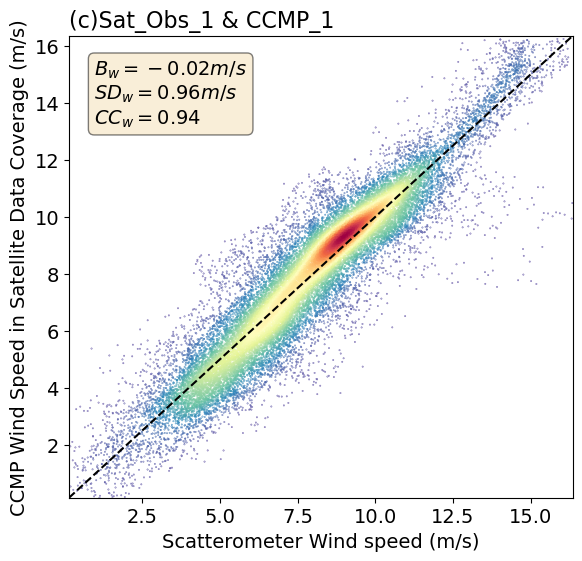

In [14]:
# 获取当前时间点的风速数据
wind_speed_pred_t = wind_speed_obs.flatten()
wind_speed_era5_t = wind_speed.flatten()
# 使用 np.isnan 函数来创建布尔掩码，标识非 NaN 的位置
valid_mask_pred = ~np.isnan(wind_speed_pred_t)
valid_mask_era5 = ~np.isnan(wind_speed_era5_t)

# 仅保留非 NaN 的值
wind_speed_pred_t = wind_speed_pred_t[valid_mask_pred]
wind_speed_era5_t = wind_speed_era5_t[valid_mask_era5]
# 计算偏差、标准差和相关系数
b_w, SD_w, r_w = calculate_statistics(wind_speed_pred_t, wind_speed_era5_t)

# 创建散点密度图
fig, ax = plt.subplots(figsize=(6.5, 6))
k = kde.gaussian_kde([wind_speed_pred_t, wind_speed_era5_t])
xi, yi = np.mgrid[wind_speed_pred_t.min():wind_speed_pred_t.max():100j, 
                  wind_speed_era5_t.min():wind_speed_era5_t.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 绘制散点密度图，设置cmap为'Spectral_r'
scatter = ax.scatter(wind_speed_pred_t, wind_speed_era5_t,s=0.1, c=k([wind_speed_pred_t, wind_speed_era5_t]), cmap='Spectral_r')

# 添加颜色条
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')

# 设置轴标签和标题
ax.set_xlabel('Scatterometer Wind speed (m/s)', fontsize=14)
ax.set_ylabel('CCMP Wind Speed in Satellite Data Coverage (m/s)', fontsize=14)
ax.set_title(f'(c)Sat_Obs_1 & CCMP_1',fontsize = 16,loc='left')


# 添加对角线
ax.plot([wind_speed_era5_t.min(), wind_speed_era5_t.max()], [wind_speed_era5_t.min(), wind_speed_era5_t.max()], 'k--')

# 设置坐标轴范围
ax.set_xlim(wind_speed_era5_t.min(), wind_speed_era5_t.max())
ax.set_ylim(wind_speed_era5_t.min(), wind_speed_era5_t.max())

# 显示偏差、标准差和相关系数
textstr = '\n'.join((
    r'$B_w=%.2f m/s$' % (b_w, ),
    r'$SD_w=%.2f m/s$' % (SD_w, ),
    r'$CC_w=%.2f$' % (r_w, )))

# 调整坐标轴刻度的字体大小
ax.tick_params(axis='both', which='major', labelsize=14)

# 放置在图的右上角
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig(f'E:/PINN_final/part2/6/cSat_Obs & CCMP风速散点密度图.eps',format='eps', bbox_inches='tight')
plt.savefig(f'E:/PINN2/fig6/cSat_Obs & CCMP风速散点密度图.eps',format='eps', bbox_inches='tight')
# plt.savefig(f'D:/PINN/PINN_new/fig6/PINN_Res & CCMP风速散点密度图.png',bbox_inches='tight')
# 显示图像
plt.show()

In [15]:
# 计算风向（弧度）
wind_dir_pred_rad = np.arctan2(selected_v2, selected_u2)
wind_dir_era5_rad = np.arctan2(selected_v, selected_u)

# 将风向转换为角度（度），并将范围调整为 [0, 360)
wind_dir_pred = (np.degrees(wind_dir_pred_rad) + 360) % 360
wind_dir_era5 = (np.degrees(wind_dir_era5_rad) + 360) % 360

In [16]:
# 计算偏差、标准差和相关系数的函数
def calculate_bias_std_correlation(pred, era5):
    N = len(pred)
    E_d = []

    for f, b in zip(pred, era5):
        diff = f - b
        if diff < -180:
            E_d.append(diff + 360)
        elif diff > 180:
            E_d.append(diff - 360)
        else:
            E_d.append(diff)
    
    b_d = np.mean(E_d)
    
    sin_theta = np.mean(np.sin(np.radians(E_d)))
    cos_theta = np.mean(np.cos(np.radians(E_d)))
    epsilon = np.sqrt(1 - (sin_theta**2 + cos_theta**2))
    SD_d = np.degrees(np.arcsin(epsilon) * (1 + 0.1547 * epsilon**3))
    
    d_f = np.radians(pred)
    d_b = np.radians(era5)
    numerator = np.sum(d_f * d_b) - np.sum(d_f) * np.sum(d_b) / N
    denominator = np.sqrt((np.sum(d_f**2) - (np.sum(d_f)**2) / N) * (np.sum(d_b**2) - (np.sum(d_b)**2) / N))
    r_d = numerator / denominator
    
    return b_d, SD_d, r_d

C:\Users\br_bo\AppData\Local\Temp\ipykernel_45776\4248520332.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([wind_dir_pred_t, wind_dir_era5_t])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


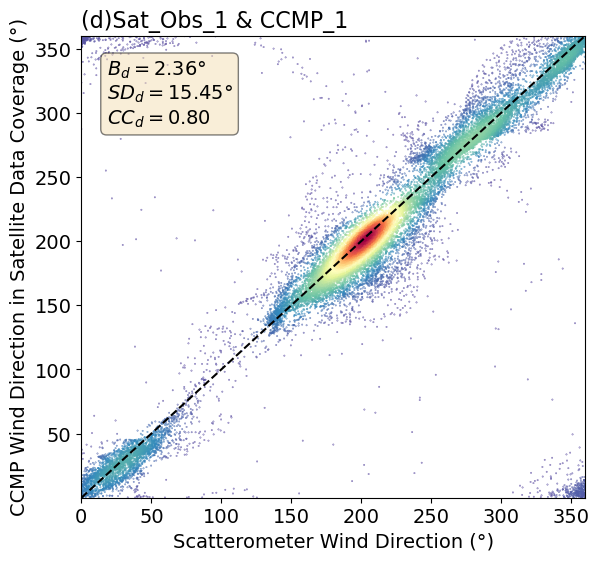

In [17]:
## 绘制风向的散点密度图

# 获取当前时间点的风向数据
wind_dir_pred_t = wind_dir_pred.flatten()
wind_dir_era5_t = wind_dir_era5.flatten()

# 使用 np.isnan 函数来创建布尔掩码，标识非 NaN 的位置
valid_mask_pred_dir = ~np.isnan(wind_dir_pred_t)
valid_mask_era5_dir = ~np.isnan(wind_dir_era5_t)

# 仅保留非 NaN 的值
wind_dir_pred_t = wind_dir_pred_t[valid_mask_pred_dir]
wind_dir_era5_t = wind_dir_era5_t[valid_mask_era5_dir]

# 计算偏差、标准差和相关系数
b_d, SD_d, r_d = calculate_bias_std_correlation(wind_dir_pred_t, wind_dir_era5_t)

# 创建散点密度图
fig, ax = plt.subplots(figsize=(6.5, 6))
k = kde.gaussian_kde([wind_dir_pred_t, wind_dir_era5_t])
xi, yi = np.mgrid[wind_dir_pred_t.min():wind_dir_pred_t.max():100j, 
                  wind_dir_era5_t.min():wind_dir_era5_t.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 绘制散点密度图，设置cmap为'Spectral_r'
scatter = ax.scatter(wind_dir_pred_t, wind_dir_era5_t, marker='o', s=0.1, c=k([wind_dir_pred_t, wind_dir_era5_t]), cmap='Spectral_r')

# # 添加颜色条
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')

# 设置轴标签和标题
ax.set_xlabel('Scatterometer Wind Direction (°)', fontsize=14)
ax.set_ylabel('CCMP Wind Direction in Satellite Data Coverage (°)', fontsize=14)
ax.set_title(f'(d)Sat_Obs_1 & CCMP_1',fontsize = 16,loc='left')

# 添加对角线
ax.plot([wind_dir_pred_t.min(), wind_dir_pred_t.max()], [wind_dir_pred_t.min(), wind_dir_pred_t.max()], 'k--')

# 设置坐标轴范围
ax.set_xlim(wind_dir_pred_t.min(), wind_dir_pred_t.max())
ax.set_ylim(wind_dir_era5_t.min(), wind_dir_era5_t.max())

# 调整坐标轴刻度的字体大小
ax.tick_params(axis='both', which='major', labelsize=14)

# 显示偏差、标准差和相关系数
textstr = '\n'.join((
    r'$B_d=%.2f °$' % (b_d, ),
    r'$SD_d=%.2f °$' % (SD_d, ),
    r'$CC_d=%.2f$' % (r_d, )))

# 放置在图的右上角
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig(f'E:/PINN2/fig6/dSat_Obs & CCMP风向散点密度图.eps',format='eps', bbox_inches='tight')
# plt.savefig(f'D:/PINN/PINN_new/fig6/PINN_Res & CCMP风向散点密度图.png', bbox_inches='tight')
# 显示图像
plt.show()

In [27]:
df = pd.read_csv('C:/Users/br_bo/Desktop/PINN_example2/whole2023-12-20/data/predictions.csv')

# 选择第一个维度的数据，这里假设是 CSV 文件的第一列
# u
data3 = df.iloc[:, 0].values  # iloc[:, 0] 选择所有行的第一列，.values 转换为 numpy 数组
print(data3.shape)
reshaped_data3 = data3.reshape((3, 201, 201))
# v
data4 = df.iloc[:, 1].values  # iloc[:, 0] 选择所有行的第一列，.values 转换为 numpy 数组
reshaped_data4 = data4.reshape((3, 201, 201))

(121203,)


In [28]:
selected_u1 = reshaped_data3[0, 0:200, 0:200]
selected_v1 = reshaped_data4[0, 0:200, 0:200]
wind_speed_pred = np.sqrt(selected_v1**2 + selected_u1**2)
# print(wind_speed)

In [29]:
# 将 wind_speed 中对应位置的值设置为 NaN
wind_speed_pred[~nan_mask] = np.nan
selected_u1[~nan_mask] = np.nan
selected_v1[~nan_mask] = np.nan

In [30]:
def calculate_statistics(w_pred, w_era5):
    N = len(w_pred)
    b_w = np.mean(w_pred - w_era5)  # 偏差
    SD_w = np.sqrt(np.sum((w_pred - w_era5 - b_w)**2) / (N - 1))  # 标准差
    r_w = np.corrcoef(w_pred, w_era5)[0, 1]  # 相关系数
    return b_w, SD_w, r_w

C:\Users\br_bo\AppData\Local\Temp\ipykernel_45776\2651318977.py:16: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([wind_speed_pred_t, wind_speed_era5_t])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


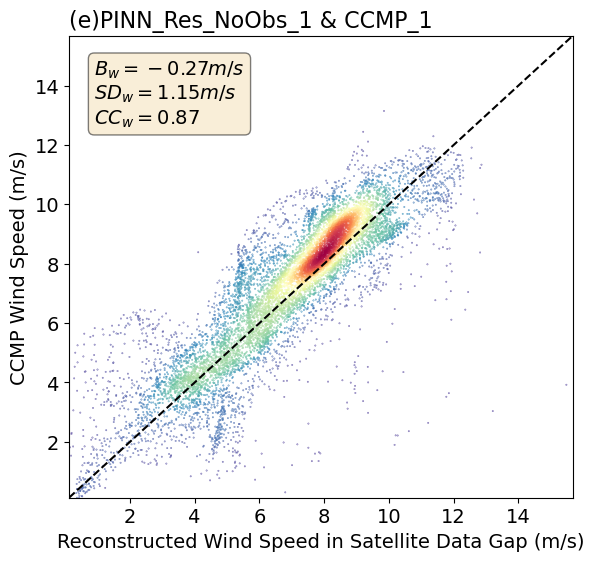

In [31]:
# 获取当前时间点的风速数据
wind_speed_pred_t = wind_speed_pred.flatten()
wind_speed_era5_t = wind_speed.flatten()
# 使用 np.isnan 函数来创建布尔掩码，标识非 NaN 的位置
valid_mask_pred = ~np.isnan(wind_speed_pred_t)
valid_mask_era5 = ~np.isnan(wind_speed_era5_t)

# 仅保留非 NaN 的值
wind_speed_pred_t = wind_speed_pred_t[valid_mask_pred]
wind_speed_era5_t = wind_speed_era5_t[valid_mask_era5]
# 计算偏差、标准差和相关系数
b_w, SD_w, r_w = calculate_statistics(wind_speed_pred_t, wind_speed_era5_t)

# 创建散点密度图
fig, ax = plt.subplots(figsize=(6.5, 6))
k = kde.gaussian_kde([wind_speed_pred_t, wind_speed_era5_t])
xi, yi = np.mgrid[wind_speed_pred_t.min():wind_speed_pred_t.max():100j, 
                  wind_speed_era5_t.min():wind_speed_era5_t.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 绘制散点密度图，设置cmap为'Spectral_r'
scatter = ax.scatter(wind_speed_pred_t, wind_speed_era5_t,s=0.1, c=k([wind_speed_pred_t, wind_speed_era5_t]), cmap='Spectral_r')

# 添加颜色条
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')

# 设置轴标签和标题
ax.set_xlabel('Reconstructed Wind Speed in Satellite Data Gap (m/s)', fontsize=14)
ax.set_ylabel('CCMP Wind Speed (m/s)', fontsize=14)
ax.set_title(f'(e)PINN_Res_NoObs_1 & CCMP_1',fontsize = 16,loc='left')


# 添加对角线
ax.plot([wind_speed_era5_t.min(), wind_speed_era5_t.max()], [wind_speed_era5_t.min(), wind_speed_era5_t.max()], 'k--')

# 设置坐标轴范围
ax.set_xlim(wind_speed_era5_t.min(), wind_speed_era5_t.max())
ax.set_ylim(wind_speed_era5_t.min(), wind_speed_era5_t.max())

# 显示偏差、标准差和相关系数
textstr = '\n'.join((
    r'$B_w=%.2f m/s$' % (b_w, ),
    r'$SD_w=%.2f m/s$' % (SD_w, ),
    r'$CC_w=%.2f$' % (r_w, )))

# 调整坐标轴刻度的字体大小
ax.tick_params(axis='both', which='major', labelsize=14)

# 放置在图的右上角
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.savefig(f'E:/PINN2/fig6/ePINN_Res_NoObs & CCMP风速散点密度图.eps',format='eps', bbox_inches='tight')
# plt.savefig(f'D:/PINN/PINN_new/fig6/PINN_Res & CCMP风速散点密度图.png',bbox_inches='tight')
# 显示图像
plt.show()

In [32]:
# 计算风向（弧度）
wind_dir_pred_rad = np.arctan2(selected_v1, selected_u1)
wind_dir_era5_rad = np.arctan2(selected_v, selected_u)

# 将风向转换为角度（度），并将范围调整为 [0, 360)
wind_dir_pred = (np.degrees(wind_dir_pred_rad) + 360) % 360
wind_dir_era5 = (np.degrees(wind_dir_era5_rad) + 360) % 360

In [33]:
# 计算偏差、标准差和相关系数的函数
def calculate_bias_std_correlation(pred, era5):
    N = len(pred)
    E_d = []

    for f, b in zip(pred, era5):
        diff = f - b
        if diff < -180:
            E_d.append(diff + 360)
        elif diff > 180:
            E_d.append(diff - 360)
        else:
            E_d.append(diff)
    
    b_d = np.mean(E_d)
    
    sin_theta = np.mean(np.sin(np.radians(E_d)))
    cos_theta = np.mean(np.cos(np.radians(E_d)))
    epsilon = np.sqrt(1 - (sin_theta**2 + cos_theta**2))
    SD_d = np.degrees(np.arcsin(epsilon) * (1 + 0.1547 * epsilon**3))
    
    d_f = np.radians(pred)
    d_b = np.radians(era5)
    numerator = np.sum(d_f * d_b) - np.sum(d_f) * np.sum(d_b) / N
    denominator = np.sqrt((np.sum(d_f**2) - (np.sum(d_f)**2) / N) * (np.sum(d_b**2) - (np.sum(d_b)**2) / N))
    r_d = numerator / denominator
    
    return b_d, SD_d, r_d

C:\Users\br_bo\AppData\Local\Temp\ipykernel_45776\104291325.py:20: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([wind_dir_pred_t, wind_dir_era5_t])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


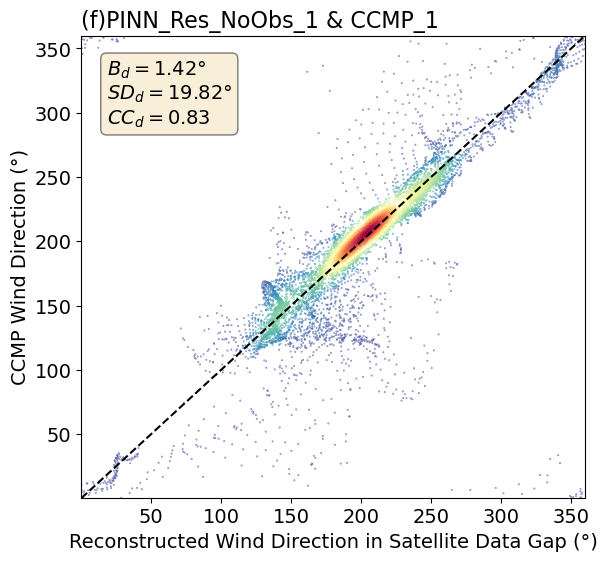

In [34]:
## 绘制风向的散点密度图

# 获取当前时间点的风向数据
wind_dir_pred_t = wind_dir_pred.flatten()
wind_dir_era5_t = wind_dir_era5.flatten()

# 使用 np.isnan 函数来创建布尔掩码，标识非 NaN 的位置
valid_mask_pred_dir = ~np.isnan(wind_dir_pred_t)
valid_mask_era5_dir = ~np.isnan(wind_dir_era5_t)

# 仅保留非 NaN 的值
wind_dir_pred_t = wind_dir_pred_t[valid_mask_pred_dir]
wind_dir_era5_t = wind_dir_era5_t[valid_mask_era5_dir]

# 计算偏差、标准差和相关系数
b_d, SD_d, r_d = calculate_bias_std_correlation(wind_dir_pred_t, wind_dir_era5_t)

# 创建散点密度图
fig, ax = plt.subplots(figsize=(6.5, 6))
k = kde.gaussian_kde([wind_dir_pred_t, wind_dir_era5_t])
xi, yi = np.mgrid[wind_dir_pred_t.min():wind_dir_pred_t.max():100j, 
                  wind_dir_era5_t.min():wind_dir_era5_t.max():100j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# 绘制散点密度图，设置cmap为'Spectral_r'
scatter = ax.scatter(wind_dir_pred_t, wind_dir_era5_t, marker='o', s=0.1, c=k([wind_dir_pred_t, wind_dir_era5_t]), cmap='Spectral_r')

# # 添加颜色条
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Density')

# 设置轴标签和标题
ax.set_xlabel('Reconstructed Wind Direction in Satellite Data Gap (°)', fontsize=14)
ax.set_ylabel('CCMP Wind Direction (°)', fontsize=14)
ax.set_title(f'(f)PINN_Res_NoObs_1 & CCMP_1',fontsize = 16,loc='left')

# 添加对角线
ax.plot([wind_dir_pred_t.min(), wind_dir_pred_t.max()], [wind_dir_pred_t.min(), wind_dir_pred_t.max()], 'k--')

# 设置坐标轴范围
ax.set_xlim(wind_dir_pred_t.min(), wind_dir_pred_t.max())
ax.set_ylim(wind_dir_era5_t.min(), wind_dir_era5_t.max())

# 调整坐标轴刻度的字体大小
ax.tick_params(axis='both', which='major', labelsize=14)

# 显示偏差、标准差和相关系数
textstr = '\n'.join((
    r'$B_d=%.2f °$' % (b_d, ),
    r'$SD_d=%.2f °$' % (SD_d, ),
    r'$CC_d=%.2f$' % (r_d, )))

# 放置在图的右上角
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig(f'E:/PINN2/fig6/fPINN_Res_NoObs & CCMP风向散点密度图.eps',format='eps', bbox_inches='tight')
# plt.savefig(f'D:/PINN/PINN_new/fig6/PINN_Res & CCMP风向散点密度图.png', bbox_inches='tight')
# 显示图像
plt.show()